# Personalized Melanoma Staging Model

The goal of this project is to create an easily understood and used tool for doctors to predict whether patients need a sentinel lymph node biopsy (SLNB). SLNB are an invasive procedure and currently doctors suggest it to patients if there is around a 10% chance for a positive biopsy. These odds are mostly based upon the depth of the melanoma, so I would like to use more data in order to create better predictions for the odds that patients need the biopsy. 

## The Data
I am using data from two sources: the National Cancer Database and the NIH's SEER Database. Currently, we are soley focusing on the NCDB's melanoma patients.

In [144]:
import pandas as pd

mela = pd.read_csv('Melanoma.csv')

In [145]:
print(len(mela.columns.values))
mela.columns.values

126


array(['PUF_CASE_ID', 'PUF_FACILITY_ID', 'FACILITY_TYPE_CD',
       'FACILITY_LOCATION_CD', 'AGE', 'SEX', 'RACE',
       'SPANISH_HISPANIC_ORIGIN', 'INSURANCE_STATUS', 'MED_INC_QUAR_00',
       'NO_HSD_QUAR_00', 'UR_CD_03', 'MED_INC_QUAR_12', 'NO_HSD_QUAR_12',
       'UR_CD_13', 'CROWFLY', 'CDCC_TOTAL_BEST', 'SEQUENCE_NUMBER',
       'CLASS_OF_CASE', 'YEAR_OF_DIAGNOSIS', 'PRIMARY_SITE', 'LATERALITY',
       'HISTOLOGY', 'BEHAVIOR', 'GRADE', 'DIAGNOSTIC_CONFIRMATION',
       'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'REGIONAL_NODES_EXAMINED',
       'DX_STAGING_PROC_DAYS', 'RX_SUMM_DXSTG_PROC', 'TNM_CLIN_T',
       'TNM_CLIN_N', 'TNM_CLIN_M', 'TNM_CLIN_STAGE_GROUP', 'TNM_PATH_T',
       'TNM_PATH_N', 'TNM_PATH_M', 'TNM_PATH_STAGE_GROUP',
       'TNM_EDITION_NUMBER', 'ANALYTIC_STAGE_GROUP', 'CS_METS_AT_DX',
       'CS_METS_EVAL', 'CS_EXTENSION', 'CS_TUMOR_SIZEEXT_EVAL',
       'CS_METS_DX_BONE', 'CS_METS_DX_BRAIN', 'CS_METS_DX_LIVER',
       'CS_METS_DX_LUNG', 'LYMPH_VASCULAR_INVASION',
 

In [146]:
mela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523492 entries, 0 to 523491
Columns: 126 entries, PUF_CASE_ID to PALLIATIVE_CARE_HOSP
dtypes: float64(64), int64(51), object(11)
memory usage: 503.2+ MB


As we can see, we have 523492 patients with 126 features (or attributes). Since it is a database, not all of these attributes would be known before a SLNB would be suggested and others of them would be irrelevant to the need for a biopsy. For example, <code>PUF_FACILITY_ID</code> (or the facility where these data were recorded) likely doesn't influence a patient's need for a biopsy. I will use the following subset of features below:

- <code>AGE</code>: The age of the patient
- <code>SEX</code>: The sex of the patient
- <code>RACE</code>: The race of the patient
- <code>SPANISH_HISPANIC_ORIGIN</code>: Indicates whether a patient is hispanic
- <code>CS_SITESPECIFIC_FACTOR_1</code>: The depth of the tumor. I rename this feature <code>DEPTH</code> to be more easily interpable
- <code>CS_SITESPECIFIC_FACTOR_2</code>: The formation of an ulcer on the skin. I rename this feature <code>ULCERATION</code> to be more easily interpable
- <code>CS_EXTENSION</code>: Indicates the extent of the spread of the melanoma.
- <code>CS_SITESPECIFIC_FACTOR_7</code>: Categories for the number of mitoses per square mm around a "hot spot". I rename this feature to <code>MITOSES</code> for interprability.
- <code>PRIMARY_SITE</code>: The main site for the melanoma. The options are:
    - <code>C44.0</code>: Skin of lips, NOS
    - <code>C44.1</code>: Eyelid
    - <code>C44.2</code>: External Ear
    - <code>C44.3</code>: Skin of other and unspecified parts of face
    - <code>C44.4</code>: Skin of scalp and neck
    - <code>C44.5</code>: Skin of the trunk
    - <code>C44.6</code>: Skin of upper limb and shoulder
    - <code>C44.7</code>: Skin of lower limb and hip
    - <code>C44.8</code>: Overlapping lesion of skin
    - <code>C44.9</code>: Skin, NOS
 
We are trying to calssify the patients into whether they had a positive lymph node biopsy or not. This is recorded in <code>TNM_PATH_N</code> or <code>REGIONAL_NODES_POSITIVE</code>.

In [147]:
#mela['TNM_PATH_N'].value_counts()

## Data Cleaning and Feature Combining

Some of the rows of the features are missing data. To start with, I will drop rows with missing data in order to have the best possible training data possible. This is a reasonable assumption currently because I have a large amount of training data, but I can work on creating a model including interpolation at a later point.

In [148]:
attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_SITESPECIFIC_FACTOR_3']
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'REGIONAL_NODES_POSITIVE']
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

#attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

In [149]:
data = mela[attribs].dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517967 entries, 0 to 523491
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AGE                       517967 non-null  int64  
 1   SEX                       517967 non-null  int64  
 2   RACE                      517967 non-null  int64  
 3   SPANISH_HISPANIC_ORIGIN   517967 non-null  int64  
 4   CS_SITESPECIFIC_FACTOR_1  517967 non-null  float64
 5   CS_SITESPECIFIC_FACTOR_2  517967 non-null  float64
 6   CS_SITESPECIFIC_FACTOR_7  517967 non-null  float64
 7   CS_EXTENSION              517967 non-null  float64
 8   PRIMARY_SITE              517967 non-null  object 
 9   CS_SITESPECIFIC_FACTOR_3  517967 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 43.5+ MB


In [150]:
#data['SPANISH_HISPANIC_ORIGIN'].value_counts() #9 means unknown if HISPANIC, 99 FOR RACE MEANS RACE UNKNOWN

In [151]:
data = data.rename(columns={'CS_SITESPECIFIC_FACTOR_1': "DEPTH", 'CS_SITESPECIFIC_FACTOR_2': 'ULCERATION',
       'CS_SITESPECIFIC_FACTOR_7': 'MITOSES', 'CS_SITESPECIFIC_FACTOR_3': 'CS_LYMPH_NODE_METS'})

In [152]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'REGIONAL_NODES_POSITIVE']
attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'ULCERATION',
        'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_LYMPH_NODE_METS']

#attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

### Dropping Missing Values
For most of our attributes, a missing value is coded as 999. We care remove these entries easily by using .dropna(). However, I need to do additional cleaning for each of our attributes.

In [153]:
new_df = data[(data != 999).all(1)]
new_df = new_df[new_df['DEPTH'] != 980]
new_df = new_df[new_df['SPANISH_HISPANIC_ORIGIN'] != 9]
new_df = new_df[new_df['MITOSES'] != 988]

#new_df.info()
new_df.head()

,AGE,SEX,RACE,SPANISH_HISPANIC_ORIGIN,DEPTH,ULCERATION,MITOSES,CS_EXTENSION,PRIMARY_SITE,CS_LYMPH_NODE_METS
4,54,1,1,0,42.0,0.0,1.0,100.0,C447,5.0
5,88,2,1,0,6.0,0.0,0.0,100.0,C447,5.0
12,60,1,1,0,270.0,10.0,10.0,300.0,C446,0.0
14,46,2,1,0,103.0,0.0,1.0,300.0,C445,5.0
17,60,1,1,0,101.0,0.0,0.0,100.0,C444,43.0


### Combining Feature Values
For some of our features, there have been two coding schema. For example, `ULCERATION` = 1.0 and `ULCERATION` = 10.0 both correspond to the presence of ulceration. Below, we combine our features in order to better represent the data.

In [154]:
new_df['ULCERATION'] = new_df['ULCERATION'].replace(10.0, 1.0)
new_df['ULCERATION'].value_counts()

0.0    127722
1.0     26484
Name: ULCERATION, dtype: int64

The `CS_EXTENSION` attribute has a combination of features for the depth of the extension as well as the Clark Level. For now, I have removed anything that isn't about the Clark Level of the tumor.

In [155]:
new_df['CS_EXTENSION'].value_counts()
new_df['CS_EXTENSION'] = new_df['CS_EXTENSION'].replace([
    310, 315, 320, 330, 335, 340, 350, 355, 360, 370, 375, 380, 400, 800, 950],
    [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999])
new_df = new_df[(new_df != 999).all(1)]
new_df['CS_EXTENSION'].value_counts()

300.0    58192
100.0    33370
200.0    28207
500.0     6278
0.0       4617
Name: CS_EXTENSION, dtype: int64

In [156]:
#new_df['REGIONAL_NODES_POSITIVE'] = new_df['REGIONAL_NODES_POSITIVE'].replace(98, 0)
#new_df['REGIONAL_NODES_POSITIVE'].value_counts()
#new_df = new_df[(new_df['REGIONAL_NODES_POSITIVE'] != 99)]

#new_df['REGIONAL_NODES_POSITIVE'] = new_df['REGIONAL_NODES_POSITIVE'] > 0 
#new_df['REGIONAL_NODES_POSITIVE'].value_counts()

In [157]:
new_df['CS_LYMPH_NODE_METS'] = new_df['CS_LYMPH_NODE_METS'].replace([5, 10],[0, 1])
new_df = new_df[new_df['CS_LYMPH_NODE_METS'] <= 1.5]
new_df['CS_LYMPH_NODE_METS'].value_counts()


0.0    117654
1.0      8971
Name: CS_LYMPH_NODE_METS, dtype: int64

In [158]:
#new_df['TNM_PATH_N'].value_counts()
#new_df = new_df[new_df['TNM_PATH_N'] != '88']
#new_df = new_df[new_df['TNM_PATH_N'] != 'pX']

#new_df['TNM_PATH_N'].value_counts()
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: 0 if x == 'pX' else x)
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: 0 if x == 'p0' else 1)
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: x if x == 0 or x == 1 else 1)


In [159]:
#new_df['TNM_PATH_N'].value_counts()

For the `RACE` attribute, there are several demographics that we only have a single representative; for simplicity, we split these demographics into white, black, and other and hispanic or not hispanic.

In [160]:
import numpy as np
new_df['RACE'].value_counts()
a = np.array(new_df['RACE'].values.tolist())
new_df['RACE'] = np.where(a > 2, 3, a).tolist()
new_df['RACE'].value_counts()#new_df['RACE'] = new_df['RACE'].apply(lambda x: [y if y <= 1 else 2 for y in x])
#new_df['RACE']

a = np.array(new_df['SPANISH_HISPANIC_ORIGIN'].values.tolist())
new_df['SPANISH_HISPANIC_ORIGIN'] = np.where(a > 1, 1, a).tolist()
new_df['SPANISH_HISPANIC_ORIGIN'].value_counts()

0    125099
1      1526
Name: SPANISH_HISPANIC_ORIGIN, dtype: int64

The other feature used is the `PRIMARY_SITE`, which codes where the melanoma is located. The features are fairly specific, so for now I coarse grain this into three categories: Head and neck, Trunk, or Extremity.

Current labels are

- `c440`: Skin of lip -> Head or Neck
- `c441`: Eyelid -> Head or Neck
- `c442`: External ear -> Head or Neck
- `c443`: Skin of other and unspecified parts of face -> Head or Neck
- `c444`: Skin of scalp and neck -> Head or Neck
- `c445`: Skin of trunk -> Trunk
- `c446`: Skin of upper limb and shoulder -> Extremity
- `c447`: Skin of lower limb and hip -> Extremity
- `c448`: Overlapping lesion of skin -> ?
- `c449`: Skin, NOS -> ?

In [161]:
#new_df['DEPTH_3'] = new_df['DEPTH'] ** 3

In [162]:
new_df['PRIMARY_SITE'].value_counts()
new_df['PRIMARY_SITE'] = new_df['PRIMARY_SITE'].replace([
    'C440', 'C441', 'C442', 'C443', 'C444', 'C445', 'C446', 'C447', 'C448', 'C449'],
    [0,0,0,0,0,1, 2,2,999,999])

new_df = new_df[(new_df != 999).all(1)]


In [163]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'DEPTH_3', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION','RACE', 'SPANISH_HISPANIC_ORIGIN',
            'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

X = new_df[attribs]
y = new_df['CS_LYMPH_NODE_METS']
#y = new_df['REGIONAL_NODES_POSITIVE']

import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

## Encoding Attributes

We have a few <b>numerical attributes</b>
- AGE
- DEPTH
- MITOSES
- CS_EXTENSION


<b>Categorical Attributes</b>
- SEX
- RACE
- SPANISH_HISPANIC_ORIGIN
- ULCERATION
- PRIMARY_SITE

In [164]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]
    
    
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["AGE","DEPTH", "CS_EXTENSION", "MITOSES"])),
    ('poly', PolynomialFeatures(degree=3)),
    ("imputer", SimpleImputer(strategy="median")),
     ])

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(['SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN','ULCERATION', 'PRIMARY_SITE'])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [165]:
corr_matrix = new_df.corr()
corr_matrix["CS_LYMPH_NODE_METS"].sort_values(ascending=False)

CS_LYMPH_NODE_METS         1.000000
DEPTH                      0.255615
CS_EXTENSION               0.211856
ULCERATION                 0.192636
PRIMARY_SITE               0.030250
SPANISH_HISPANIC_ORIGIN    0.017813
RACE                       0.007583
SEX                       -0.016723
MITOSES                   -0.053161
AGE                       -0.067096
Name: CS_LYMPH_NODE_METS, dtype: float64

In [166]:
train_num = num_pipeline.fit_transform(X_train)
print(len(train_num))

100855


In [167]:
cat_pipeline.fit_transform(X_train);

### Pre-processing the data

Now, I want to take out the numerical attributes and the categorical attributes and format the data according to the pipeline above. In addition, I split the data again into a cross-validation set in order to better tune the model parameters.

In [168]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

x_train = preprocess_pipeline.fit_transform(X_train)
x_train
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_cv, x_train = x_train[:10000, :], x_train[10000:,:]
y_cv, y_train = y_train[:10000], y_train[10000:]

# Methods for Estimating

Our baseline for estimating is to predict the majority class, i.e. that everyone doesn't need the SLNB. This gives us a point of comparison for the accuracy of our method: we must perform better than this in a meaningful way for our new model to be performing well.

In [169]:
from sklearn.base import BaseEstimator

class BaseLine(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1))

In [170]:
from sklearn.model_selection import cross_val_score
base_line_clf = BaseLine()
base_scores = cross_val_score(base_line_clf,x_train,y_train,cv=10,scoring="accuracy")
base_scores.mean()

0.9288206850191122

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(x_train,y_train)
log_scores = cross_val_score(log_clf, x_train,y_train,cv=10,scoring="accuracy")
y_pred = log_clf.predict(x_train)
log_score = accuracy_score(y_train,y_pred)
print(log_score)
log_scores.mean()

importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
#y_pred = y_pred == 2
#y_simple = y_train == 2
log_f1 = f1_score(y_train,y_pred)
log_recall = recall_score(y_train, y_pred)
log_precision = precision_score(y_train,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")



0.928765615541247
Feature: 0, Score: 0.00000
Feature: 1, Score: -0.99332
Feature: 2, Score: 8.00622
Feature: 3, Score: 4.91696
Feature: 4, Score: 1.70398
Feature: 5, Score: -0.39094
Feature: 6, Score: 2.35686
Feature: 7, Score: 1.06943
Feature: 8, Score: 0.69911
Feature: 9, Score: -6.22254
Feature: 10, Score: -0.83089
Feature: 11, Score: 0.77320
Feature: 12, Score: 0.85482
Feature: 13, Score: 0.37607
Feature: 14, Score: -0.99170
Feature: 15, Score: -1.15701
Feature: 16, Score: -0.68076
Feature: 17, Score: 0.01395
Feature: 18, Score: 0.70476
Feature: 19, Score: -2.06235
Feature: 20, Score: -1.34757
Feature: 21, Score: 0.34364
Feature: 22, Score: -0.08109
Feature: 23, Score: -0.22837
Feature: 24, Score: -0.91608
Feature: 25, Score: 0.83818
Feature: 26, Score: 1.20022
Feature: 27, Score: -1.24567
Feature: 28, Score: -1.63713
Feature: 29, Score: -0.21992
Feature: 30, Score: 0.45426
Feature: 31, Score: -2.47288
Feature: 32, Score: 0.29364
Feature: 33, Score: -1.18818
Feature: 34, Score: -0.

0.9324
The precision is 0.5185185185185185, the recall is 0.0206794682422452, and the f1 score is 0.03977272727272727


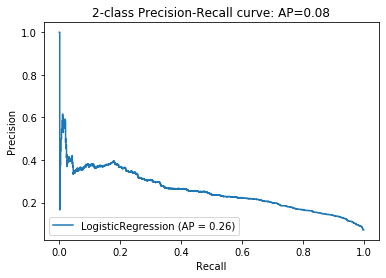

In [172]:
#x_test = preprocess_pipeline.transform(X_test) #running our train_set through the pipeline
#x_test = sc.transform (x_test)
y_pred = log_clf.predict(x_cv)

#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
log_score = accuracy_score(y_cv, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y_cv,y_pred)
log_recall = recall_score(y_cv, y_pred)
log_precision = precision_score(y_cv,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")


y_proba = log_clf.predict_proba(x_cv)
from sklearn.metrics import precision_recall_curve
#precision, recall, thresholds = precision_recall_curve(y_cv, y_proba)

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_cv, y_pred)

disp = plot_precision_recall_curve(log_clf, x_cv, y_cv)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))



misclassified = np.where(y_cv != y_pred)

In [173]:
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

super_misclassified = np.where(y_proba[:][:,1] < 0.10)

x_features = x_miss[super_misclassified]

len(x_features)

#
#import seaborn as sns
##y_proba[:][:,0]
#sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

#min(y_proba[:][:,1])
#min(y_proba[:][:,0])

201

In [174]:
print(confusion_matrix(y_cv, y_pred))


[[9310   13]
 [ 663   14]]


0.8487480050630125
The precision is 0.1954792800334868, the recall is 0.36106386268749036, and the f1 score is 0.2536389311318705
[[74778  9610]
 [ 4132  2335]]
0.8507
The precision is 0.18174726989079562, the recall is 0.34416543574593794, and the f1 score is 0.23787646758550282
[[8274 1049]
 [ 444  233]]
0.00075809342667025
0.3936235116945451


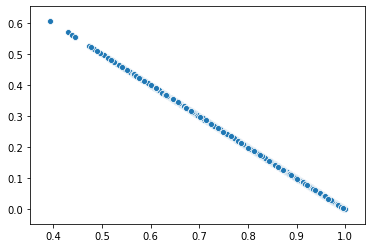

In [175]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_train)
gnb_score = accuracy_score(y_train, y_pred)
print(gnb_score)
#print(y_test)
gnb_f1 = f1_score(y_train,y_pred)
gnb_recall = recall_score(y_train, y_pred)
gnb_precision = precision_score(y_train,y_pred)
print(f"The precision is {gnb_precision}, the recall is {gnb_recall}, and the f1 score is {gnb_f1}")
print(confusion_matrix(y_train, y_pred))

y_pred = gnb.fit(x_train, y_train).predict(x_cv)
gnb_score = accuracy_score(y_cv, y_pred)
print(gnb_score)
#print(y_test)
gnb_f1 = f1_score(y_cv,y_pred)
gnb_recall = recall_score(y_cv, y_pred)
gnb_precision = precision_score(y_cv,y_pred)
print(f"The precision is {gnb_precision}, the recall is {gnb_recall}, and the f1 score is {gnb_f1}")
print(confusion_matrix(y_cv, y_pred))

misclassified = np.where(y_cv != y_pred)
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

import seaborn as sns
#y_proba[:][:,0]
sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

print(min(y_proba[:][:,1]))
print(min(y_proba[:][:,0]))

0.950778713334434
The precision is 0.904993909866017, the recall is 0.3446729550023195, and the f1 score is 0.4992161254199329
[[84154   234]
 [ 4238  2229]]
0.9102
The precision is 0.1536050156739812, the recall is 0.0723781388478582, and the f1 score is 0.09839357429718876
[[9053  270]
 [ 628   49]]
0.002753796886688686
0.43910202795559317


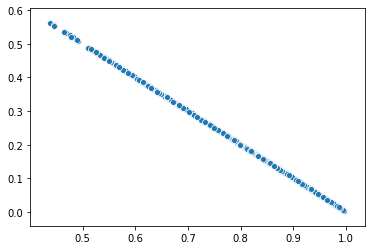

In [184]:
##Prone to Overfitting

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42, max_depth = 15)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_train)
tree_score = accuracy_score(y_train, y_pred)
print(tree_score)
#print(y_test)
tree_f1 = f1_score(y_train,y_pred)
tree_recall = recall_score(y_train, y_pred)
tree_precision = precision_score(y_train,y_pred)
print(f"The precision is {tree_precision}, the recall is {tree_recall}, and the f1 score is {tree_f1}")
print(confusion_matrix(y_train, y_pred))

y_pred = tree.predict(x_cv)
tree_score = accuracy_score(y_cv, y_pred)
print(tree_score)
#print(y_test)
tree_f1 = f1_score(y_cv,y_pred)
tree_recall = recall_score(y_cv, y_pred)
tree_precision = precision_score(y_cv,y_pred)
print(f"The precision is {tree_precision}, the recall is {tree_recall}, and the f1 score is {tree_f1}")
print(confusion_matrix(y_cv, y_pred))

misclassified = np.where(y_cv != y_pred)
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

import seaborn as sns
#y_proba[:][:,0]
sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

print(min(y_proba[:][:,1]))
print(min(y_proba[:][:,0]))

0.9102
The precision is 0.9791666666666666, the recall is 0.021802999845368796, and the f1 score is 0.042656179095446986 for depth 10
[[84385     3]
 [ 6326   141]]
0.9321
The precision is 0.3333333333333333, the recall is 0.0029542097488921715, and the f1 score is 0.005856515373352856 for depth 10
[[9319    4]
 [ 675    2]]
0.002753796886688686
0.3936235116945451
0.9102
The precision is 0.9976435304198801, the recall is 0.7201175197154785, and the f1 score is 0.836461607543781 for depth 20
[[84377    11]
 [ 1810  4657]]
0.9267
The precision is 0.2878787878787879, the recall is 0.056129985228951254, and the f1 score is 0.09394313967861558 for depth 20
[[9229   94]
 [ 639   38]]
0.002753796886688686
0.3936235116945451
0.9102
The precision is 0.9929818834666232, the recall is 0.940776248646977, and the f1 score is 0.9661743687470224 for depth 30
[[84345    43]
 [  383  6084]]
0.9198
The precision is 0.2171945701357466, the recall is 0.07090103397341212, and the f1 score is 0.106904231625

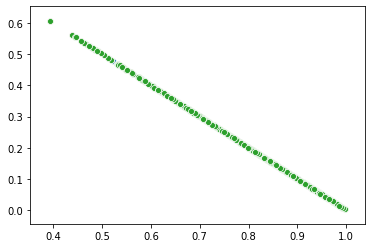

In [185]:
from sklearn.ensemble import RandomForestClassifier

depth = [10, 20, 30]

for d in depth:

    forest = RandomForestClassifier(max_depth = d,random_state=42)
    forest.fit(x_train,y_train)
    y_pred = forest.predict(x_train)
    forest_score = accuracy_score(y_train, y_pred)
    print(tree_score)
    #print(y_test)
    forest_f1 = f1_score(y_train,y_pred)
    forest_recall = recall_score(y_train, y_pred)
    forest_precision = precision_score(y_train,y_pred)
    print(f"The precision is {forest_precision}, the recall is {forest_recall}, and the f1 score is {forest_f1} for depth {d}")
    print(confusion_matrix(y_train, y_pred))
    
    y_pred = forest.predict(x_cv)
    forest_score = accuracy_score(y_cv, y_pred)
    print(forest_score)
    #print(y_test)
    forest_f1 = f1_score(y_cv,y_pred)
    forest_recall = recall_score(y_cv, y_pred)
    forest_precision = precision_score(y_cv,y_pred)
    print(f"The precision is {forest_precision}, the recall is {forest_recall}, and the f1 score is {forest_f1} for depth {d}")
    print(confusion_matrix(y_cv, y_pred))
    misclassified = np.where(y_cv != y_pred)
    x_miss = x_cv[misclassified]
    y_proba = log_clf.predict_proba(x_miss)

    import seaborn as sns
#y_proba[:][:,0]
    sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

    print(min(y_proba[:][:,1]))
    print(min(y_proba[:][:,0]))



In [178]:
# import tensorflow as tf # Note that tf is the standard way to import tensorflow, much like pd is to pandas
# from tensorflow import keras

# # The code to build the neural network architecture. 

# # We will use the Keras sequential API to build the neural network one layer at a time
# NN = keras.models.Sequential()

# # Next add an input layer
# # '.Flatten' tells keras to reshape the data with this layer and not transform the inputs
# # We specified the input shape as [28,28] since that is the dimensions of our input arrays
# #print(len(x_train), len(x_train[0]))
# NN.add(keras.layers.Flatten(input_shape=(len(x_train[0]),)))

# # Make the hidden layers
# # The '.Dense' part just tells keras/tensorflow that this is just a regular densely connected layer.
# NN.add(keras.layers.Dense(10, activation='relu'))
# NN.add(keras.layers.Dense(5, activation='relu'))

# # Lastly add the output layer
# # Remember to specify the softmax activation function
# NN.add(keras.layers.Dense(2, activation='sigmoid'))

In [179]:
#NN.summary()

In [180]:
# weights, biases = NN.layers[1].get_weights()

In [181]:
# #from keras.optimizers import SGD
# opt = keras.optimizers.SGD(learning_rate=0.1)
#  NN.compile(loss = 'sparse_categorical_crossentropy', # This is explained much more below
#           optimizer = opt, # sgd stands for stochastic gradient descent
#           metrics = ['accuracy']) # These are other metrics you would like to calculate after each epoch

In [182]:
# history = NN.fit(x_train, y_train, epochs = 30,
#                  validation_data = (x_cv, y_cv))

In [183]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# pd.DataFrame(history.history).plot(figsize=(8,5))
# plt.grid(True)
# plt.gca().set_ylim(0,1)
# plt.show();